In [1]:
from pathlib import Path

import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
DATA_DIR = Path("/Users/rgareev/data/ny-tlc/src")
train_path = DATA_DIR / "fhv_tripdata_2021-01.parquet"
validation_path = DATA_DIR / "fhv_tripdata_2021-02.parquet"

In [3]:
!ls -al $DATA_DIR

total 44032
drwxr-xr-x  4 rgareev  staff       128 May 22 16:00 .
drwxr-xr-x  3 rgareev  staff        96 May 22 16:00 ..
-rw-r--r--@ 1 rgareev  staff  11886281 May 20 16:39 fhv_tripdata_2021-01.parquet
-rw-r--r--@ 1 rgareev  staff  10645466 May 20 16:39 fhv_tripdata_2021-02.parquet


In [4]:
src_train_df = pd.read_parquet(train_path)

In [5]:
src_train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 200.6 MB


In [6]:
src_train_df.sample(10)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
1152860,B01231,2021-01-31 22:23:01,2021-01-31 22:48:30,NaN,17.0,None,B02887
227761,B01899,2021-01-07 14:40:14,2021-01-07 14:58:55,NaN,NaN,None,B01899
167887,B03060,2021-01-06 08:28:25,2021-01-06 09:38:37,NaN,55.0,None,B03060
698692,B02846,2021-01-20 08:12:56,2021-01-20 09:19:00,NaN,147.0,None,B02846
1012059,B01061,2021-01-28 08:22:08,2021-01-28 08:35:33,NaN,250.0,None,B01061
234068,B01087,2021-01-07 17:02:05,2021-01-07 17:14:02,230.0,236.0,None,B01087
982340,B01231,2021-01-27 12:09:06,2021-01-27 12:23:16,NaN,36.0,None,B02883
844105,B01239,2021-01-23 19:06:46,2021-01-23 19:28:37,NaN,167.0,None,B01239
973420,B02550,2021-01-27 09:03:04,2021-01-27 09:12:39,NaN,177.0,None,B02550
51909,B01231,2021-01-02 23:04:25,2021-01-02 23:07:05,NaN,17.0,None,B02918


In [7]:
CATEGORICAL = ['PUlocationID', 'DOlocationID']
TARGET_COL = 'duration'
FEATURE_COLS = CATEGORICAL

In [10]:
def prepare_data(src_df):
    src_df['duration'] = src_df.dropOff_datetime - src_df.pickup_datetime
    src_df.duration = src_df.duration / pd.Timedelta(1, 'sec') / 60
    print("Duration (minutes):", src_df.duration.describe(), sep='\n')
    df = src_df[(src_df.duration >= 1) & (src_df.duration <= 60)].copy()
    print(f"Dropped {src_df.shape[0] - df.shape[0]} rows")
    print("Missing values: ", df.isna().mean(), sep='\n')
    df.PUlocationID.fillna(-1, inplace=True)
    df.DOlocationID.fillna(-1, inplace=True)
    df[CATEGORICAL] = df[CATEGORICAL].astype(str)
    return df[FEATURE_COLS + [TARGET_COL]]

In [11]:
train_df = prepare_data(src_train_df)
train_df.info()

Duration (minutes):
count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64
Dropped 44286 rows
Missing values: 
dispatching_base_num      0.000000
pickup_datetime           0.000000
dropOff_datetime          0.000000
PUlocationID              0.835273
DOlocationID              0.133270
SR_Flag                   1.000000
Affiliated_base_number    0.000697
duration                  0.000000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109826 entries, 0 to 1154111
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   PUlocationID  1109826 non-null  object 
 1   DOlocationID  1109826 non-null  object 
 2   duration      1109826 non-null  float64
dtypes: float64(1), object(2)
memory usage: 33.9+ MB


In [12]:
train_df.sample(10)

,PUlocationID,DOlocationID,duration
37410,-1.0,69.0,26.633333
151180,-1.0,227.0,38.116667
957256,-1.0,165.0,18.866667
837051,-1.0,147.0,21.850000
1134652,-1.0,242.0,12.416667
25816,-1.0,20.0,14.216667
270299,-1.0,11.0,25.916667
837720,-1.0,168.0,20.700000
810641,122.0,129.0,20.183333
213929,92.0,10.0,25.183333


In [18]:
src_valid_df = pd.read_parquet(validation_path)

In [19]:
valid_df = prepare_data(src_valid_df)

Duration (minutes):
count    1.037692e+06
mean     2.070699e+01
std      1.611084e+02
min      1.666667e-02
25%      8.000000e+00
50%      1.410000e+01
75%      2.373333e+01
max      1.109190e+05
Name: duration, dtype: float64
Dropped 47579 rows
Missing values: 
dispatching_base_num      0.000000
pickup_datetime           0.000000
dropOff_datetime          0.000000
PUlocationID              0.857135
DOlocationID              0.136106
SR_Flag                   1.000000
Affiliated_base_number    0.000000
duration                  0.000000
dtype: float64


## Extract features

In [13]:
oh_encoder = DictVectorizer()

In [15]:
oh_encoder.fit(train_df[FEATURE_COLS].to_dict('records'))

DictVectorizer()

In [16]:
X_train = oh_encoder.transform(train_df[FEATURE_COLS].to_dict('records'))

In [17]:
X_train.shape

(1109826, 525)

In [20]:
X_valid = oh_encoder.transform(valid_df[FEATURE_COLS].to_dict('records'))
X_valid.shape

(990113, 525)

## Extract labels

In [21]:
y_train = train_df[TARGET_COL]
y_valid = valid_df[TARGET_COL]

# Train

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rmse = lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)

In [23]:
lr = LinearRegression()

In [24]:
%%time
lr.fit(X_train, y_train)

CPU times: user 46.5 s, sys: 11.3 s, total: 57.9 s
Wall time: 9.94 s


LinearRegression()

In [25]:
y_train_pred = lr.predict(X_train)
rmse(y_train, y_train_pred)

10.52851910721245

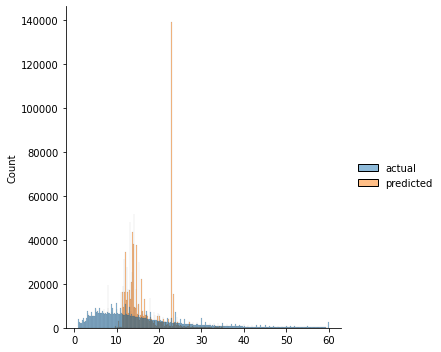

In [27]:
sns.displot(pd.DataFrame({'actual' : y_train, 'predicted' : y_train_pred}))

# Evaluate

In [28]:
y_valid_pred = lr.predict(X_valid)
rmse(y_valid, y_valid_pred)

11.0142832180344

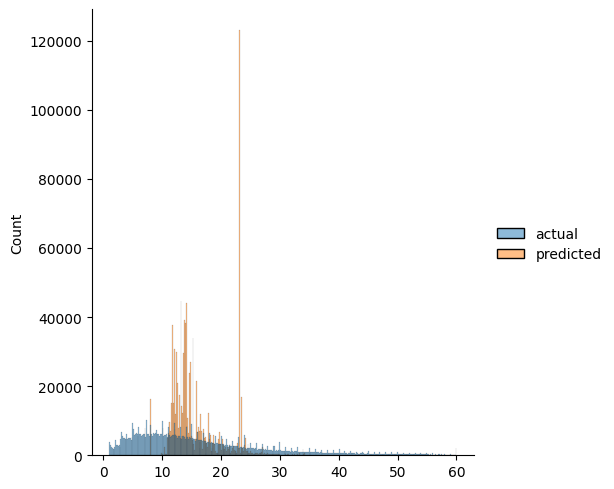

In [29]:
sns.displot(pd.DataFrame({'actual' : y_valid, 'predicted' : y_valid_pred}))